In [52]:
import pandas as pd
from google.cloud import bigquery as bq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

service_account_path = '/home/yusuf/DataScience/dream_games/ybektas20.json'
client = bq.Client.from_service_account_json(service_account_path)
# 1. Data Ingestion
# Query the q3_table_user_metrics table
user_metrics_query = """
SELECT *
FROM `casedreamgames.case_db.q3_table_user_metrics`
"""
df_metrics = client.query(user_metrics_query).result().to_dataframe()
print("First 5 rows of q3_table_user_metrics:")
print(df_metrics.head())

# 2. Target Creation
# Create a binary target variable: 1 if d30_revenue > 0, else 0
df_metrics['made_purchase'] = (df_metrics['d30_revenue'] > 0).astype(int)


/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


First 5 rows of q3_table_user_metrics:
              user_id    country  age platform network  time_spend  \
0  dlxsqb7178890300b2    Zephyra   53      ios  Oyster          71   
1  dlxsqb7178884891b2  Thalassia   33      ios   Piggy          88   
2  dlxsqb7179152264b2   Sunridge   64      ios   Piggy           2   
3  dlxsqb7179044724b2    Zephyra   51      ios   Piggy          11   
4  dlxsqb7178985060b2    Zephyra   70      ios   Piggy          38   

   coin_spend  coin_earn  level_success  level_fail  level_start  \
0           0          0              0           0            0   
1           0          0              0           0            0   
2           0          0              0           0            0   
3           0          0              0           0            0   
4           0          0              0           0            0   

   booster_spend  booster_earn  coin_amount  event_participate  shop_open  \
0              0             0         2000           

In [53]:
df_metrics.made_purchase.value_counts(normalize=True)

made_purchase
0    0.921651
1    0.078349
Name: proportion, dtype: float64

In [54]:
df_metrics[['level_fail', 'level_success']].tail(100)

,level_fail,level_success
342419,146,254
342420,321,254
342421,71,254
342422,88,254
342423,112,254
...,...,...
342514,97,255
342515,95,255
342516,135,255
342517,88,255


In [65]:

features = [
    'country', 'age', 'platform', 'network', 'time_spend',
    'coin_spend', 'coin_earn', 'level_success', 'level_fail', 'level_start',
    'booster_spend', 'booster_earn', 'coin_amount', 'event_participate',
    'shop_open'
]
X = df_metrics[features]
y = df_metrics['made_purchase']




array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'time_spend'}>,
        <Axes: title={'center': 'coin_spend'}>,
        <Axes: title={'center': 'coin_earn'}>],
       [<Axes: title={'center': 'level_success'}>,
        <Axes: title={'center': 'level_fail'}>,
        <Axes: title={'center': 'level_start'}>,
        <Axes: title={'center': 'booster_spend'}>],
       [<Axes: title={'center': 'booster_earn'}>,
        <Axes: title={'center': 'coin_amount'}>,
        <Axes: title={'center': 'event_participate'}>,
        <Axes: title={'center': 'shop_open'}>],
       [<Axes: title={'center': 'd30_revenue'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

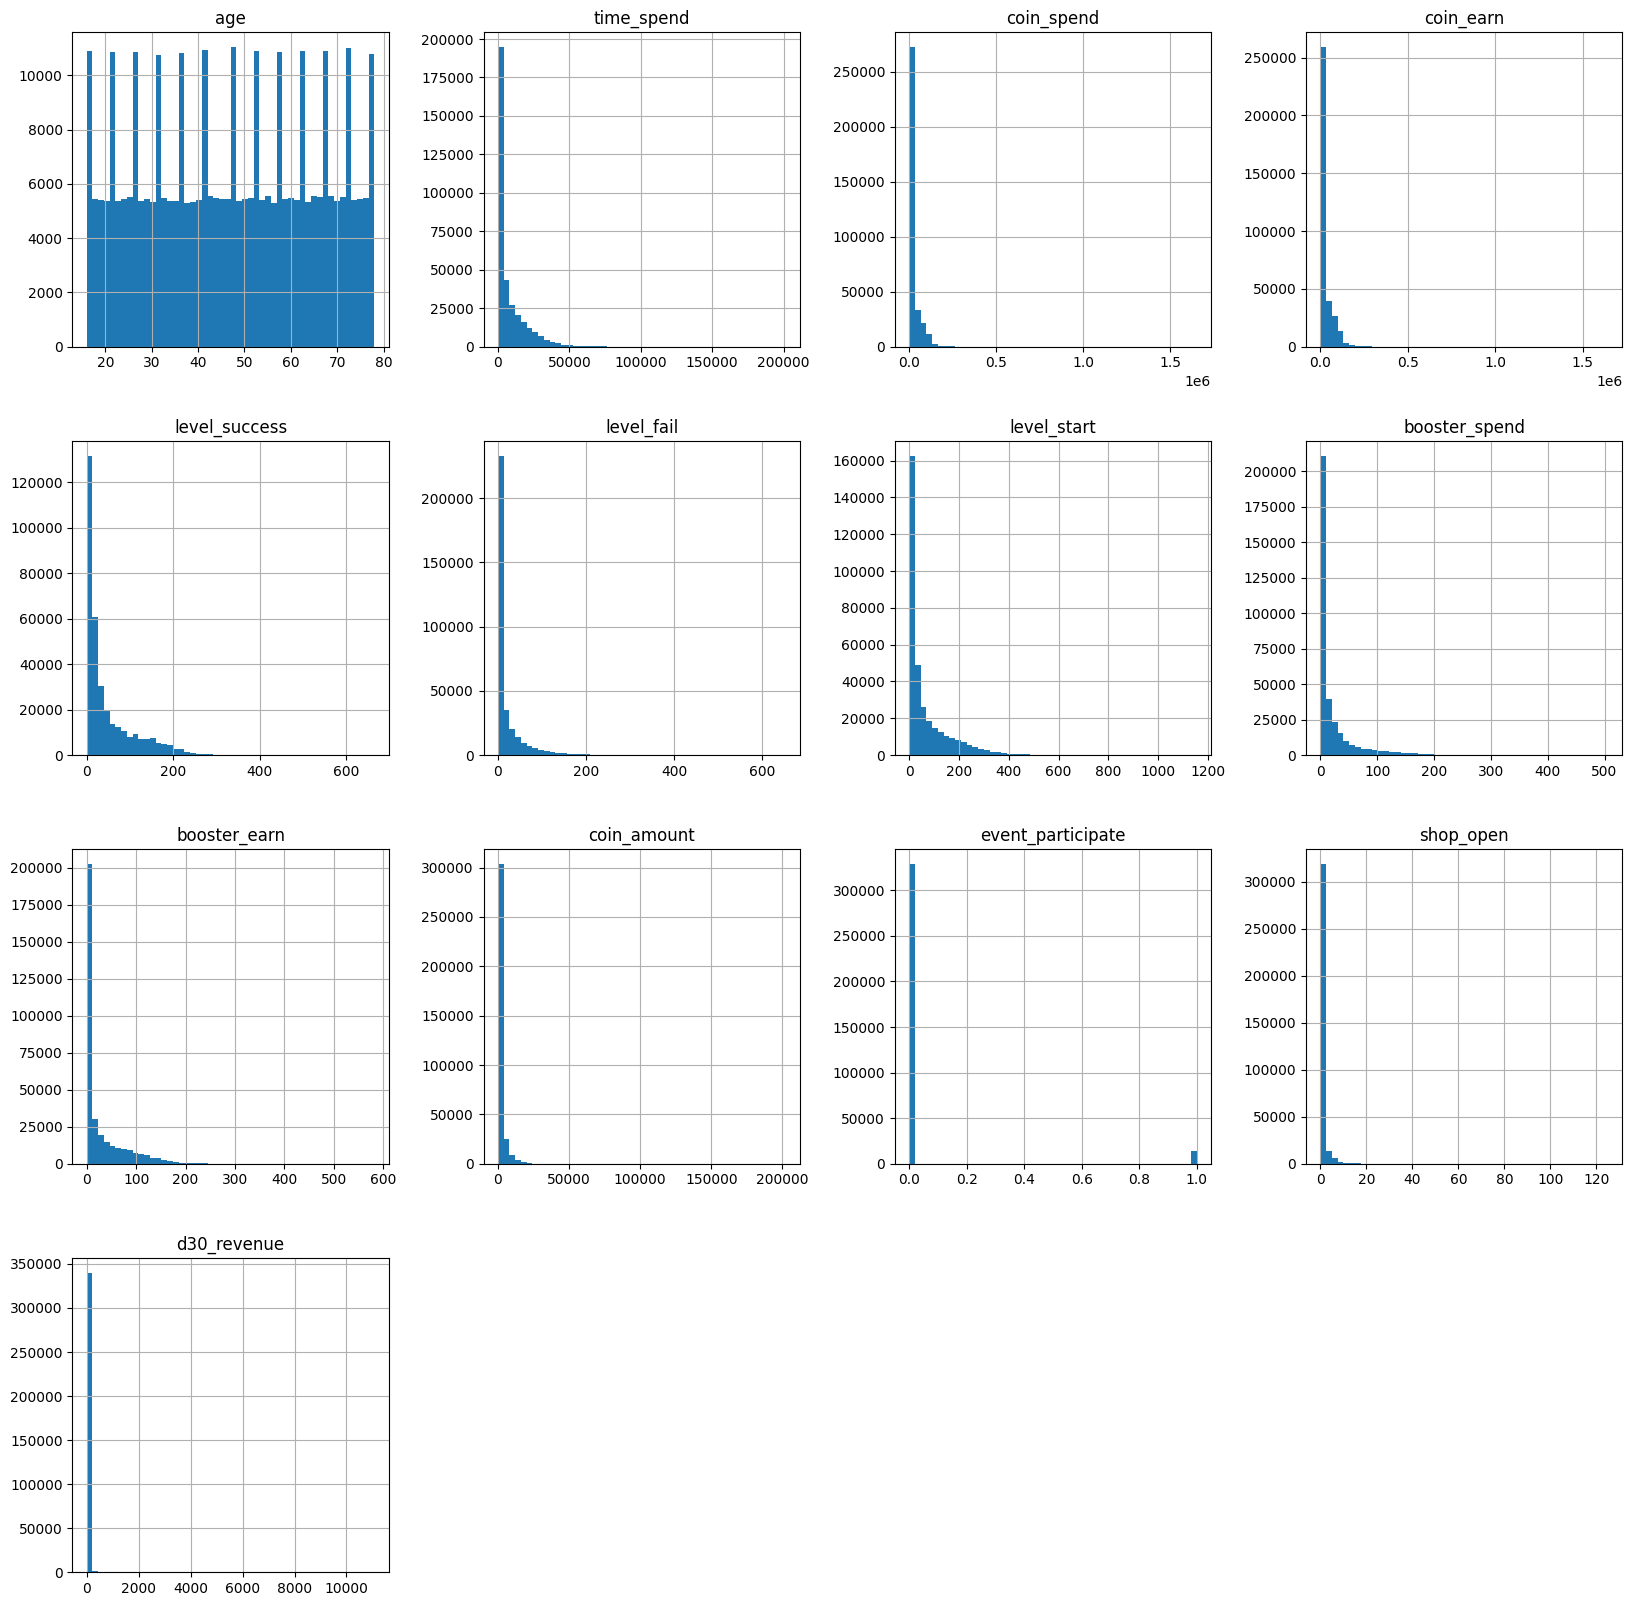

In [56]:
X.hist(figsize=(20, 20), bins=50)

<Axes: xlabel='country'>

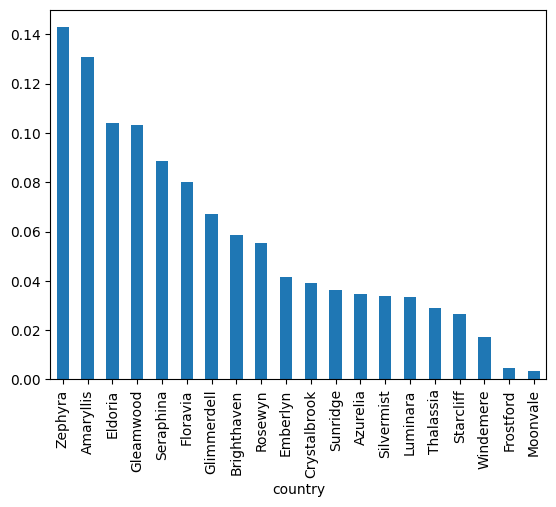

In [57]:
y.groupby(X['country']).mean().sort_values(ascending=False).plot(kind='bar')

<Axes: xlabel='platform'>

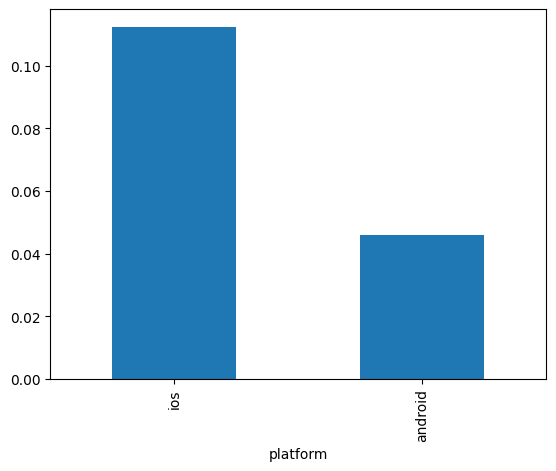

In [58]:
y.groupby(X['platform']).mean().sort_values(ascending=False).plot(kind='bar')

<Axes: xlabel='network'>

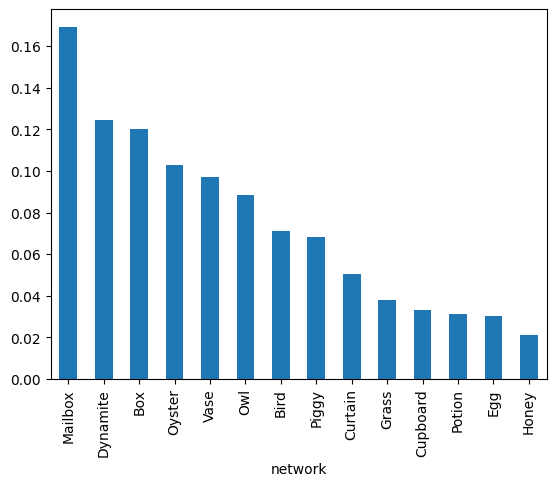

In [59]:
y.groupby(X['network']).mean().sort_values(ascending=False).plot(kind='bar')

In [66]:
# One-hot encoding for the 'country' column
X = pd.get_dummies(X, columns=['country'], prefix='country')
X = pd.get_dummies(X, columns=['platform'], prefix='platform')
X = pd.get_dummies(X, columns=['network'], prefix='network')
X.columns

Index(['age', 'time_spend', 'coin_spend', 'coin_earn', 'level_success',
       'level_fail', 'level_start', 'booster_spend', 'booster_earn',
       'coin_amount', 'event_participate', 'shop_open', 'country_Amaryllis',
       'country_Azurelia', 'country_Brighthaven', 'country_Crystalbrook',
       'country_Eldoria', 'country_Emberlyn', 'country_Floravia',
       'country_Frostford', 'country_Gleamwood', 'country_Glimmerdell',
       'country_Luminara', 'country_Moonvale', 'country_Rosewyn',
       'country_Seraphina', 'country_Silvermist', 'country_Starcliff',
       'country_Sunridge', 'country_Thalassia', 'country_Windemere',
       'country_Zephyra', 'platform_android', 'platform_ios', 'network_Bird',
       'network_Box', 'network_Cupboard', 'network_Curtain',
       'network_Dynamite', 'network_Egg', 'network_Grass', 'network_Honey',
       'network_Mailbox', 'network_Owl', 'network_Oyster', 'network_Piggy',
       'network_Potion', 'network_Vase'],
      dtype='object')

In [67]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342519 entries, 0 to 342518
Data columns (total 48 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   age                   342519 non-null  Int64  
 1   time_spend            342519 non-null  Int64  
 2   coin_spend            342519 non-null  Int64  
 3   coin_earn             342519 non-null  Int64  
 4   level_success         342519 non-null  Int64  
 5   level_fail            342519 non-null  Int64  
 6   level_start           342519 non-null  Int64  
 7   booster_spend         342519 non-null  Int64  
 8   booster_earn          342519 non-null  Int64  
 9   coin_amount           342519 non-null  Int64  
 10  event_participate     342519 non-null  Int64  
 11  shop_open             342519 non-null  float64
 12  country_Amaryllis     342519 non-null  bool   
 13  country_Azurelia      342519 non-null  bool   
 14  country_Brighthaven   342519 non-null  bool   
 15  

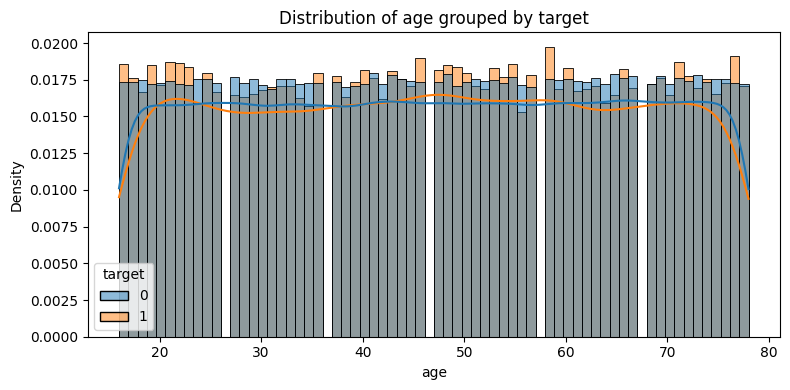

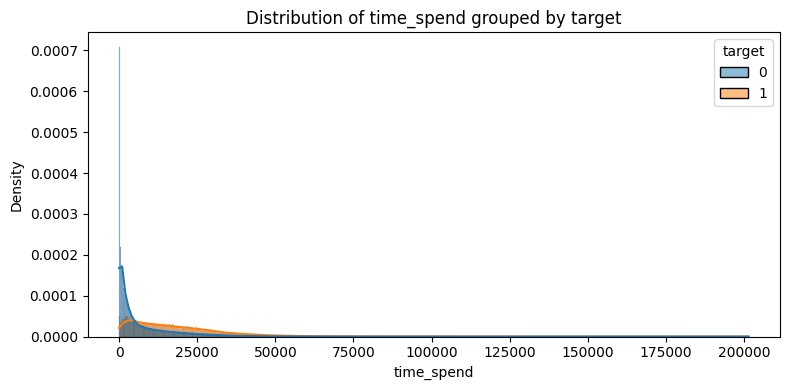

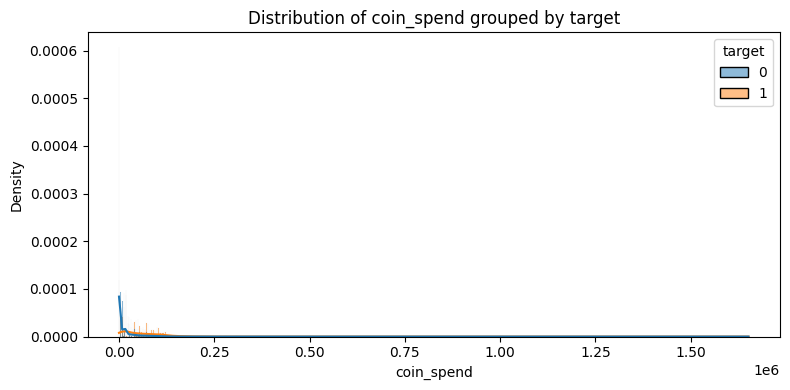

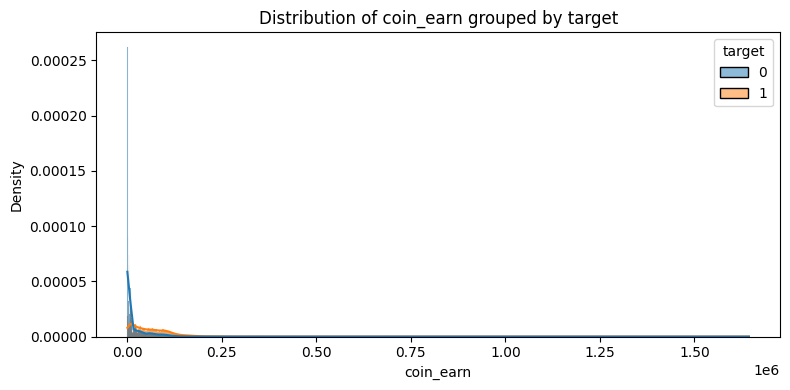

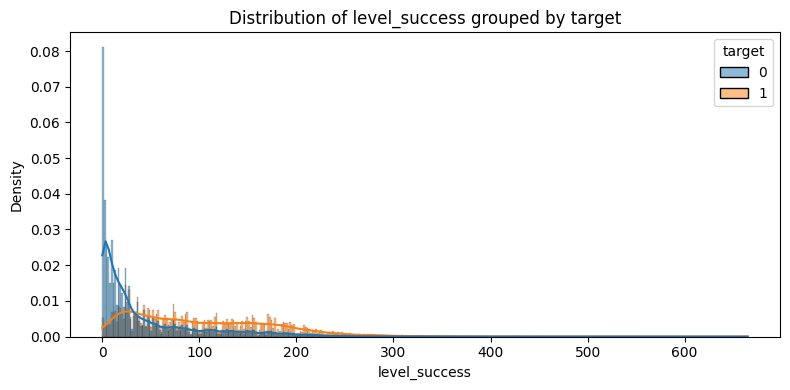

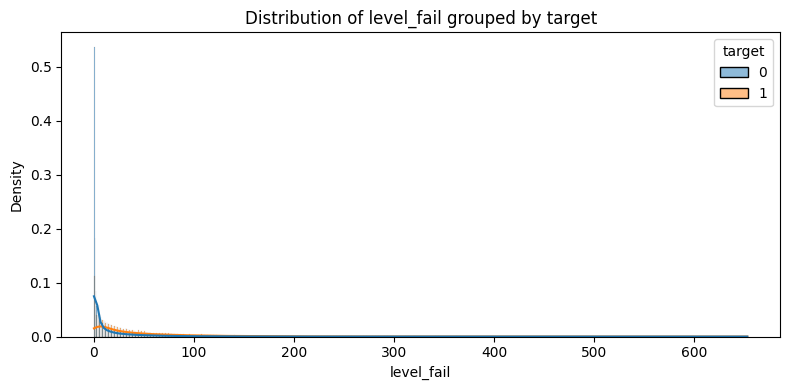

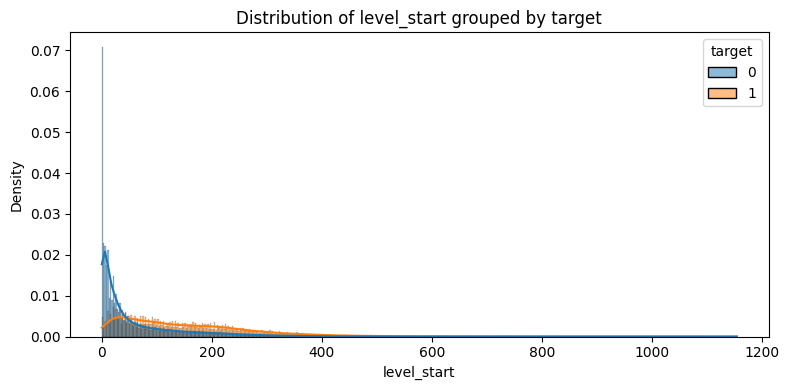

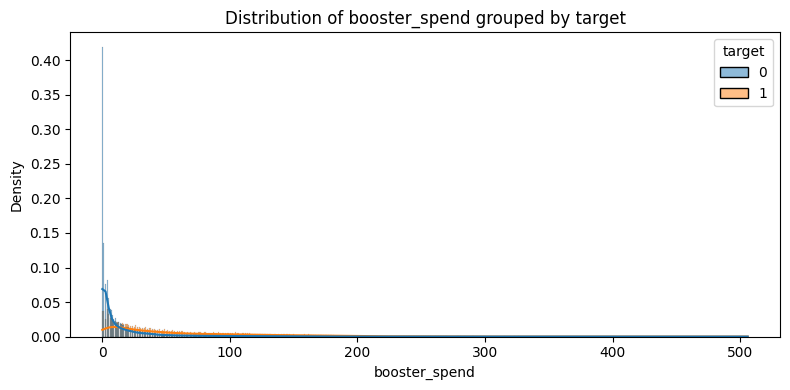

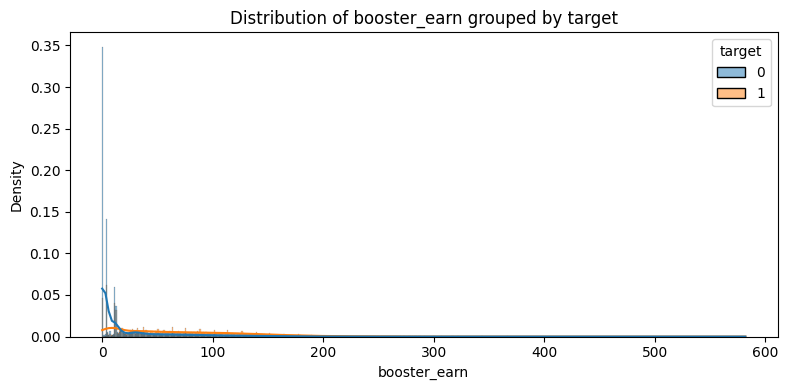

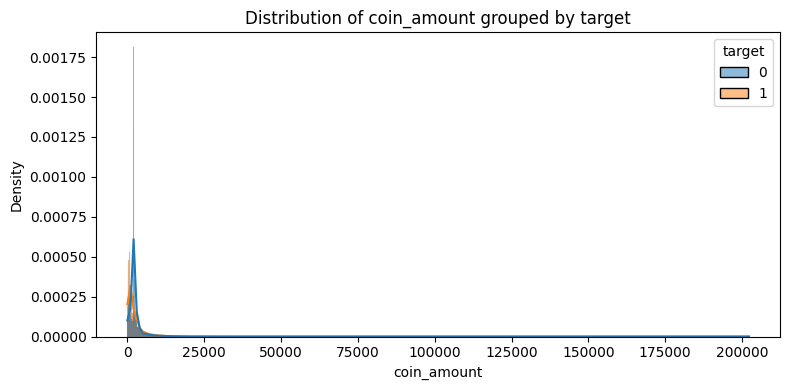

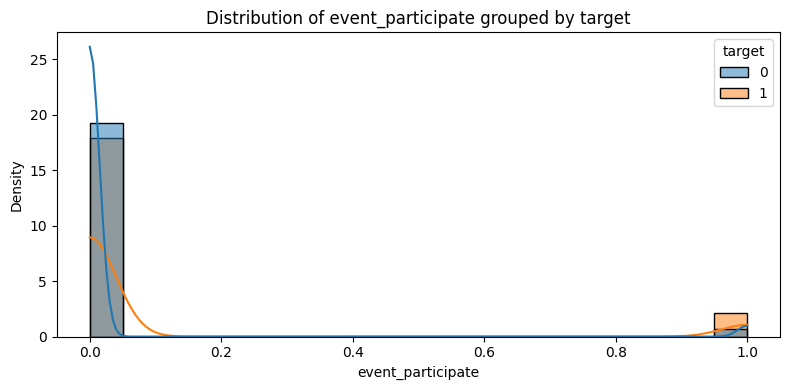

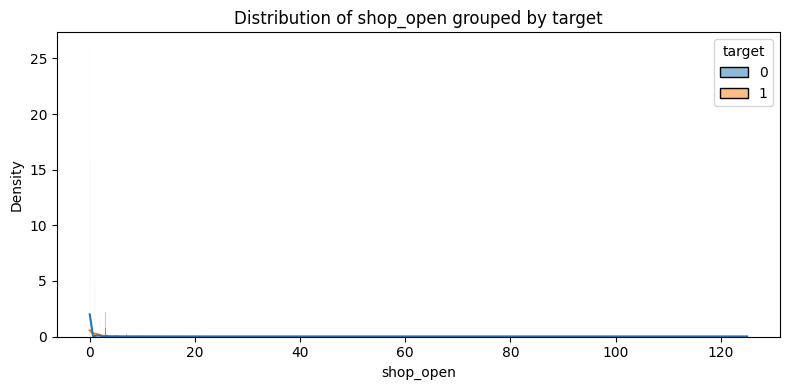

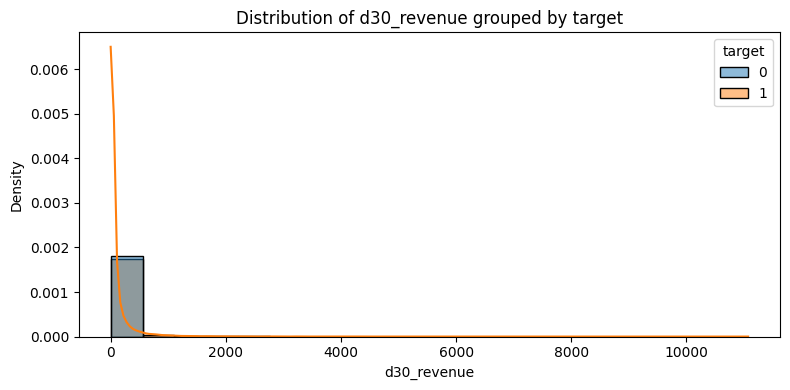

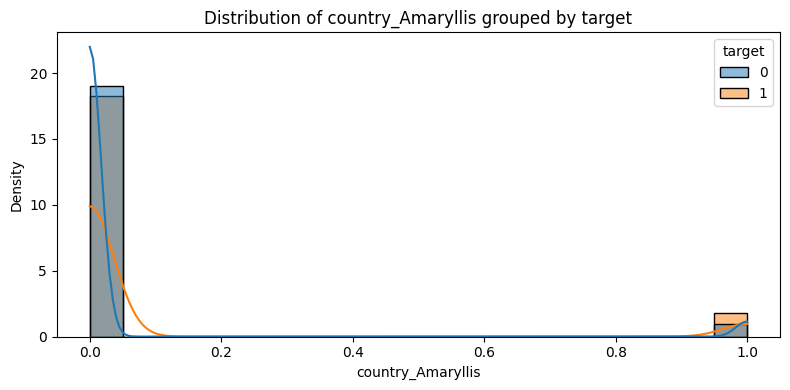

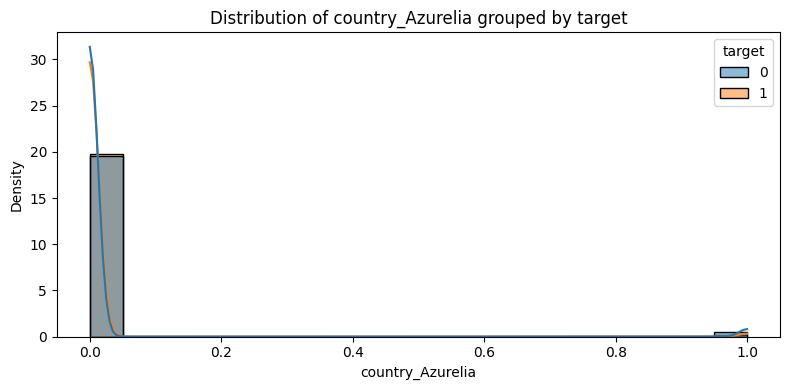

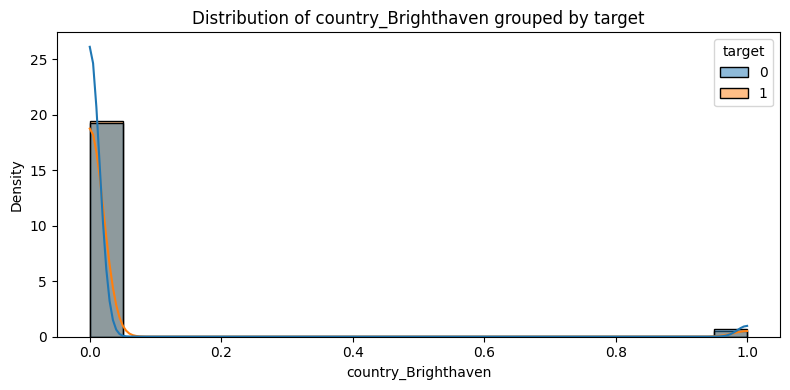

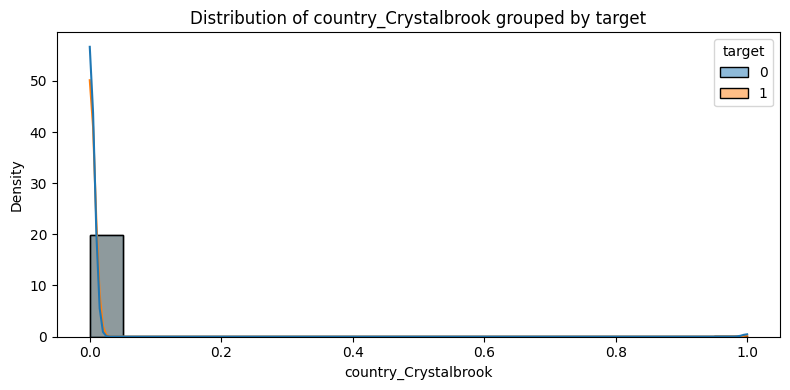

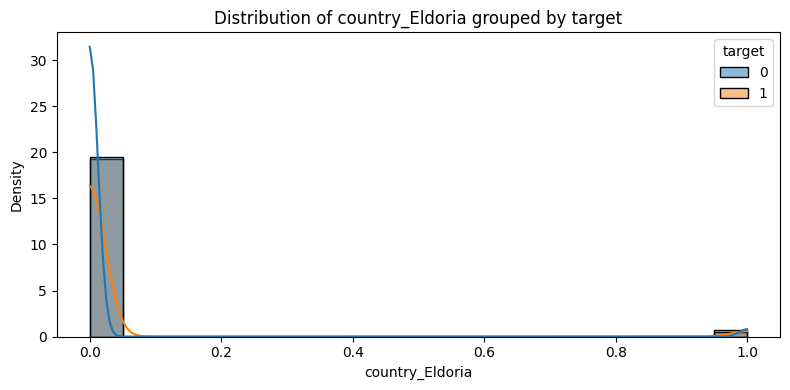

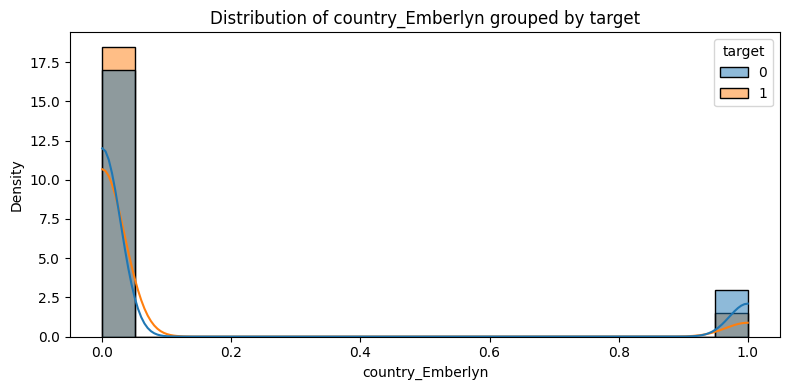

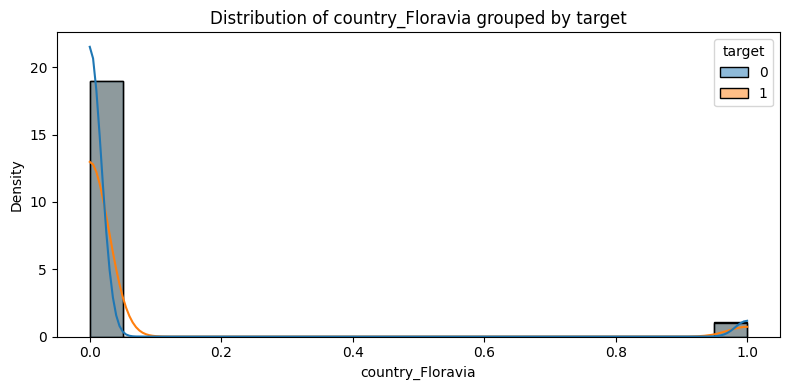

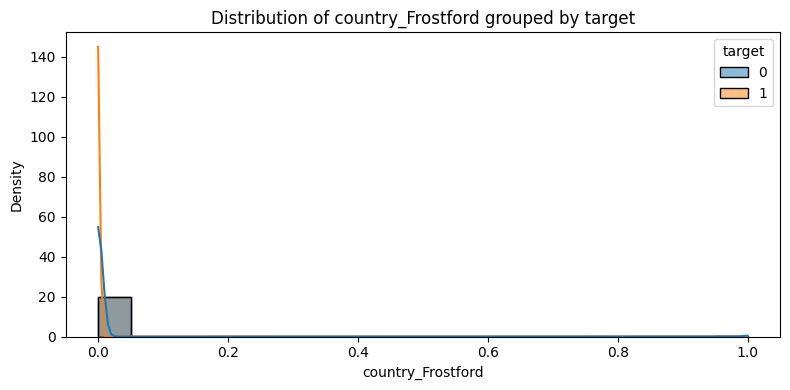

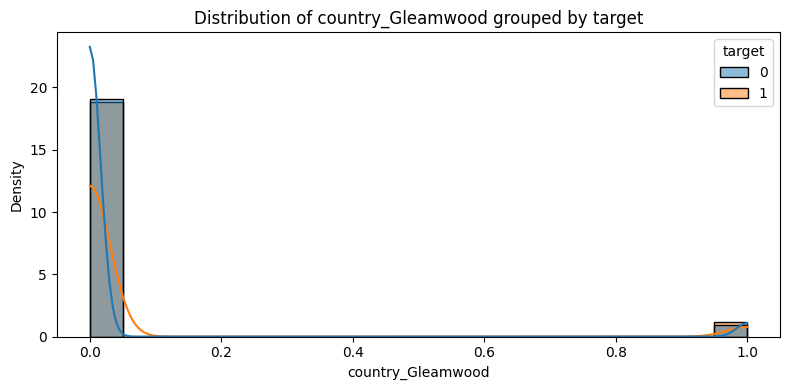

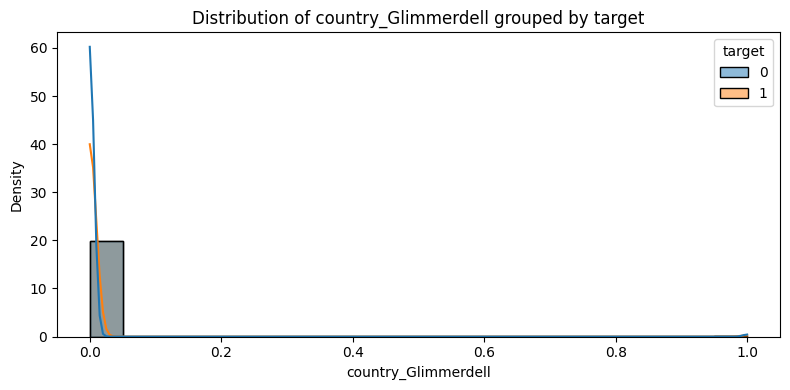

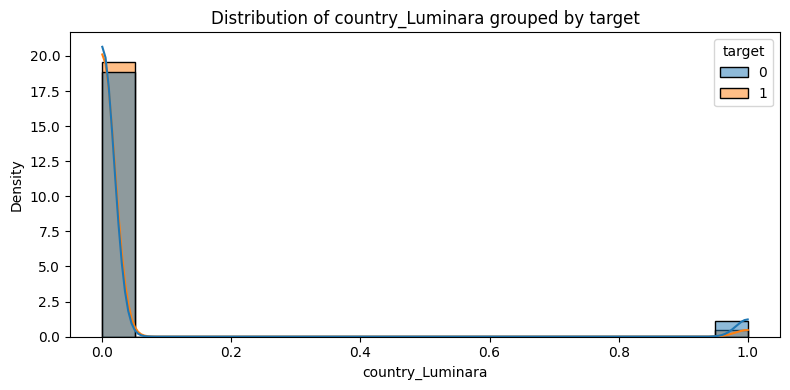

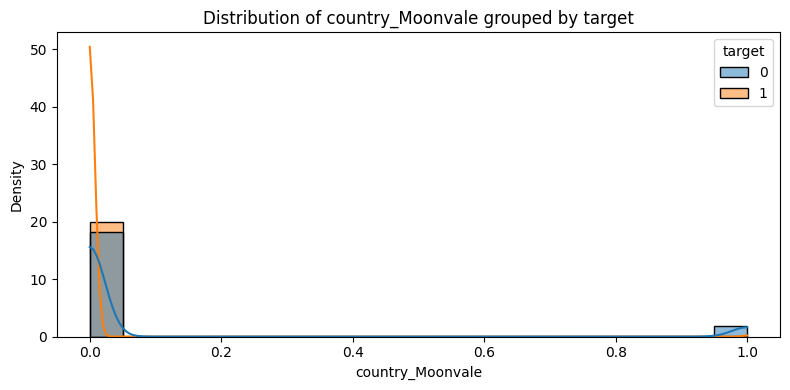

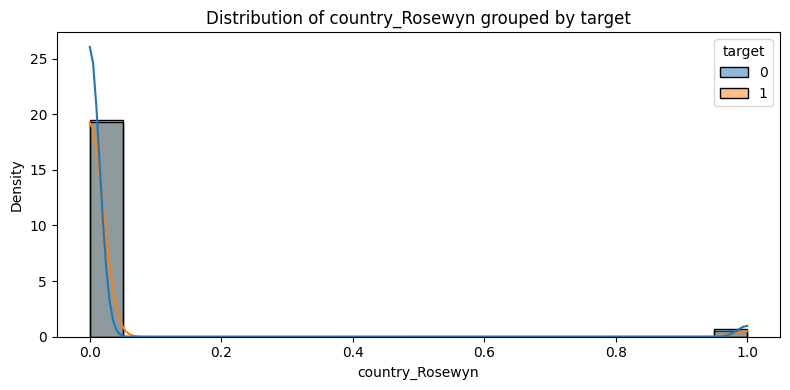

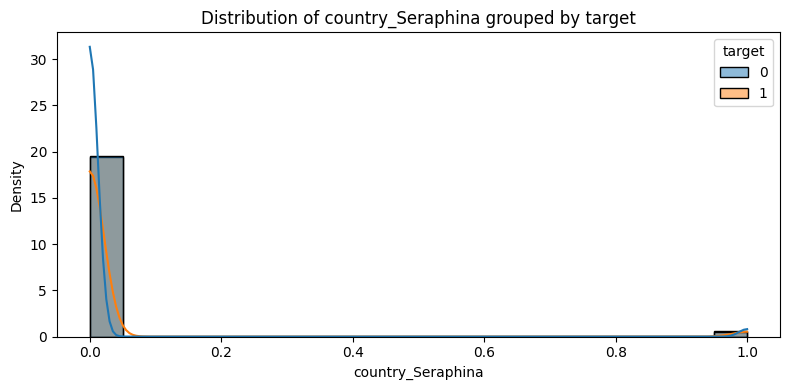

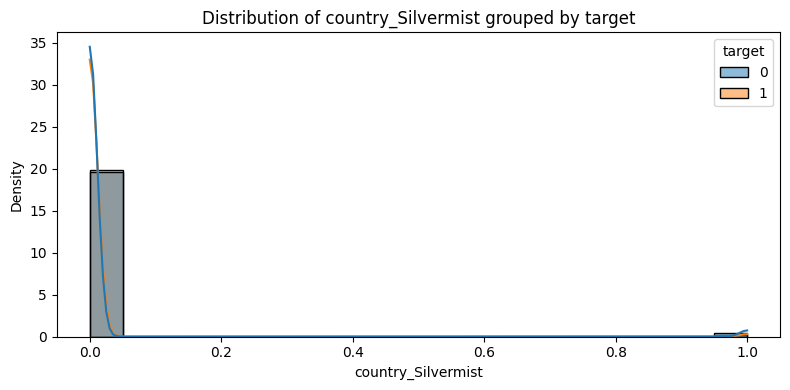

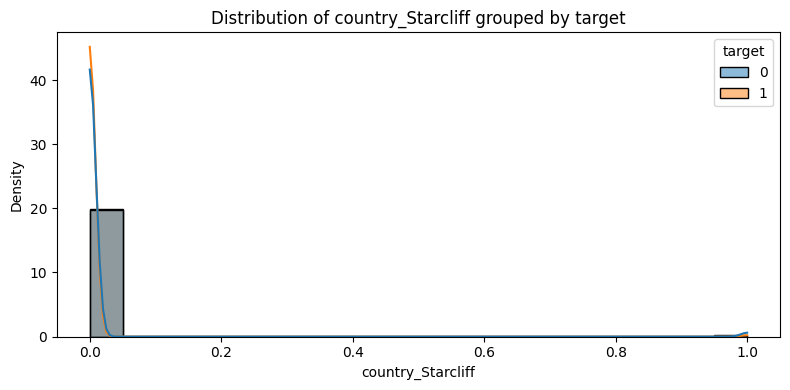

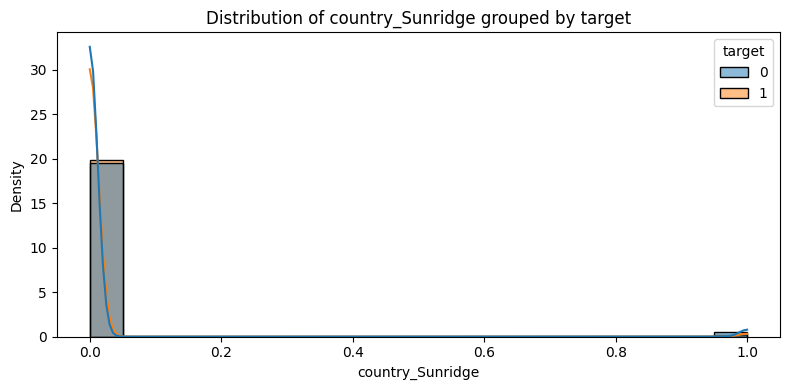

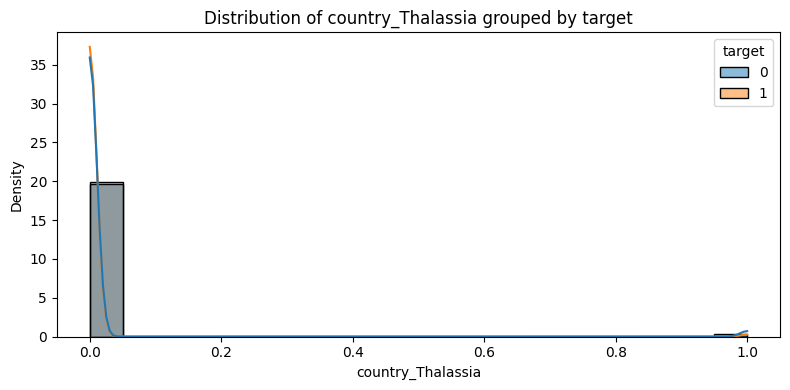

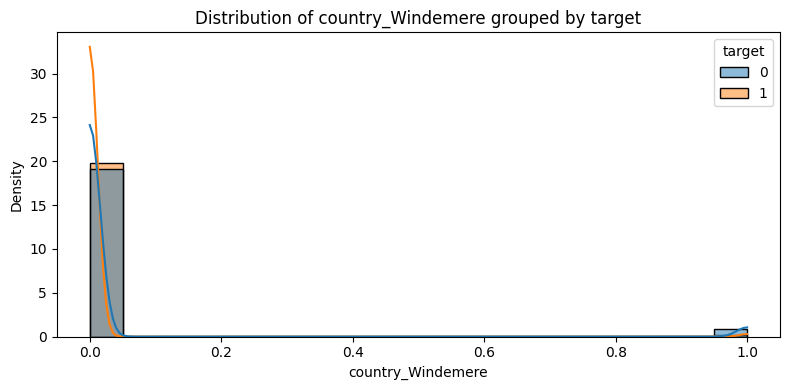

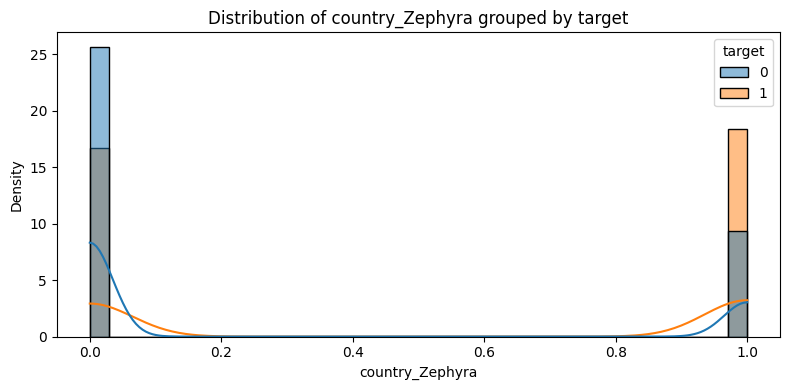

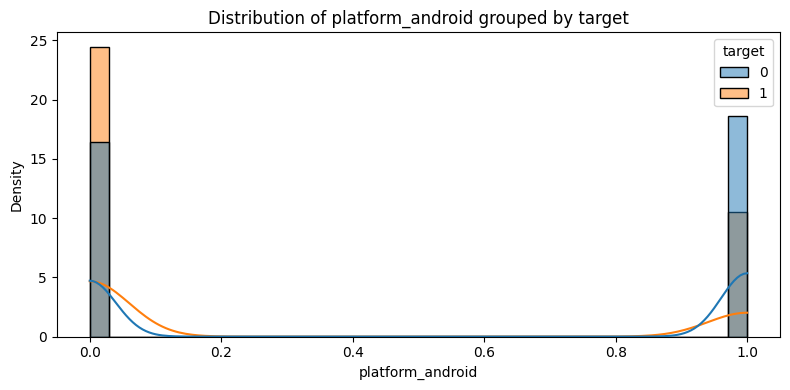

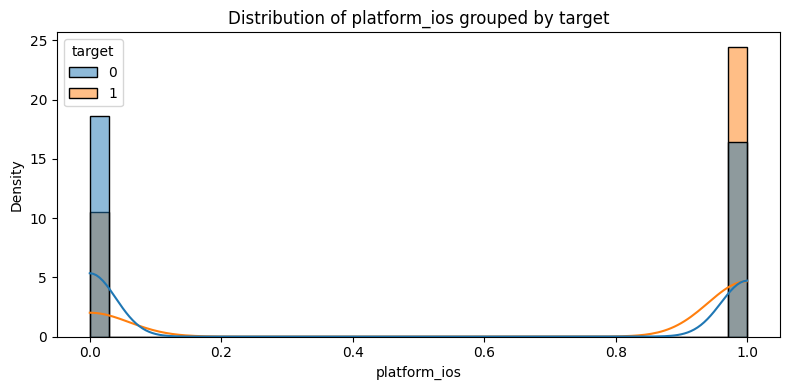

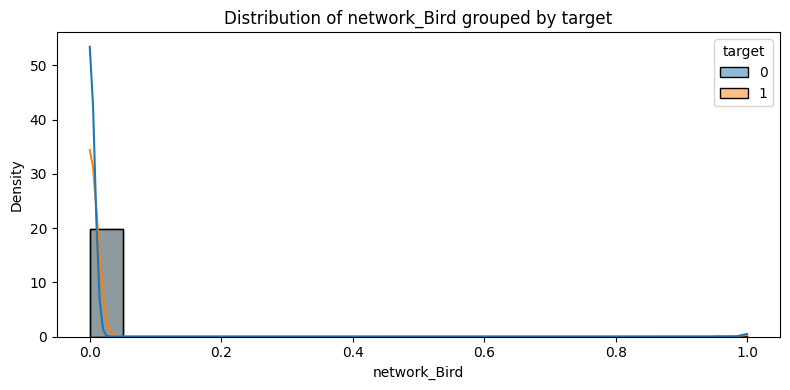

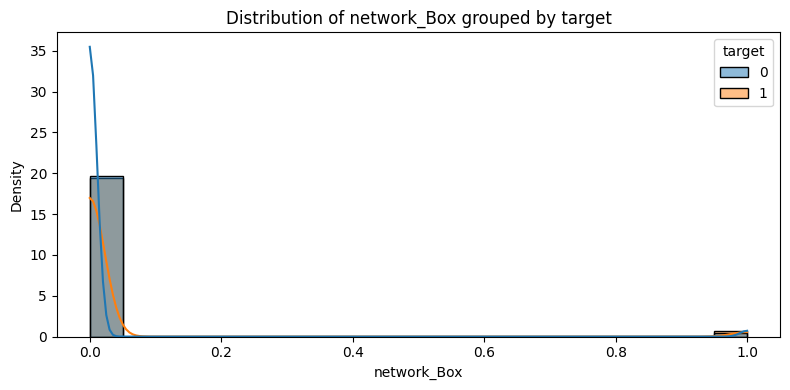

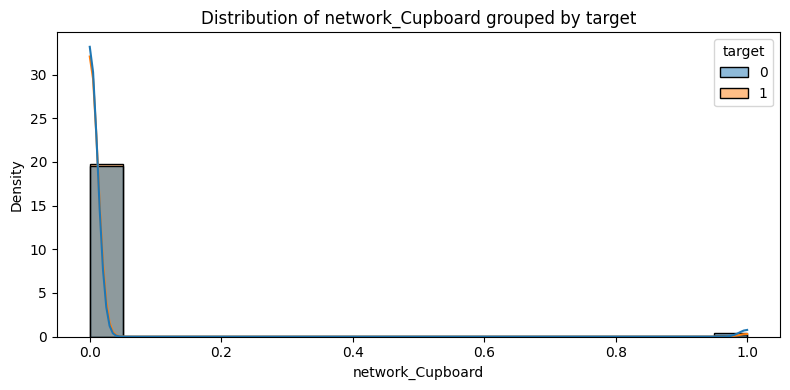

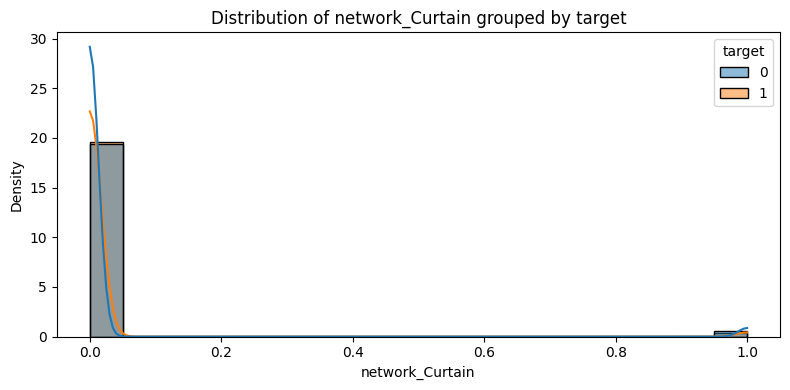

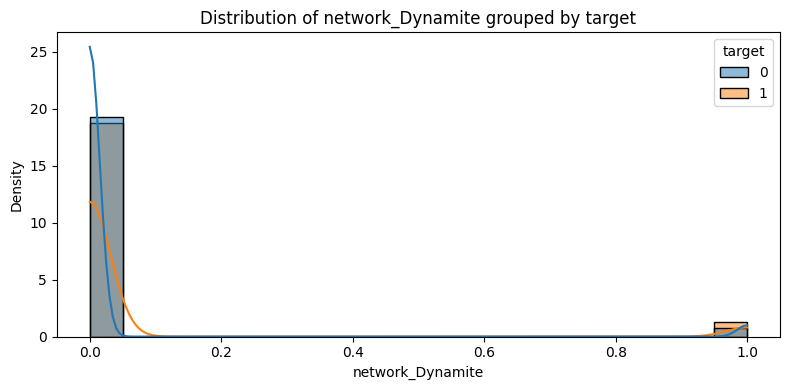

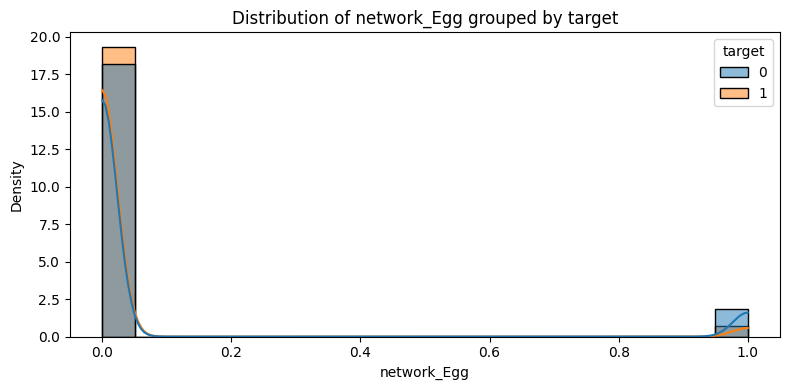

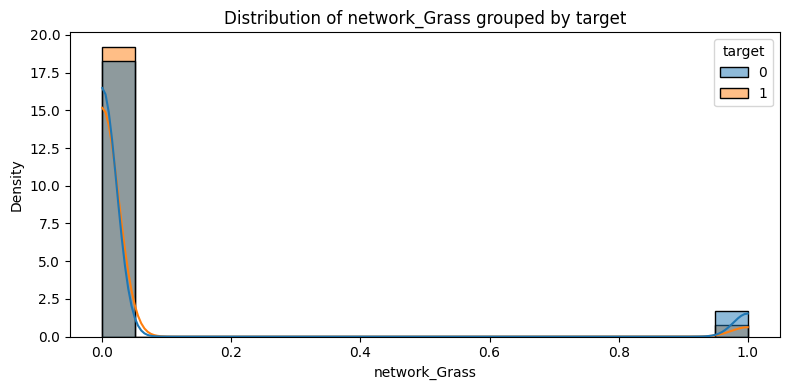

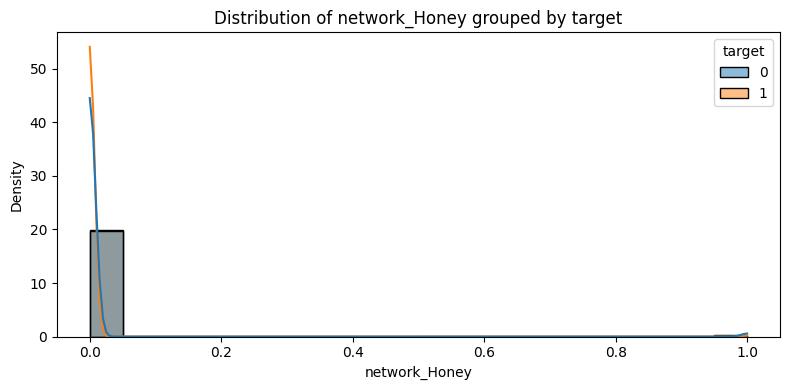

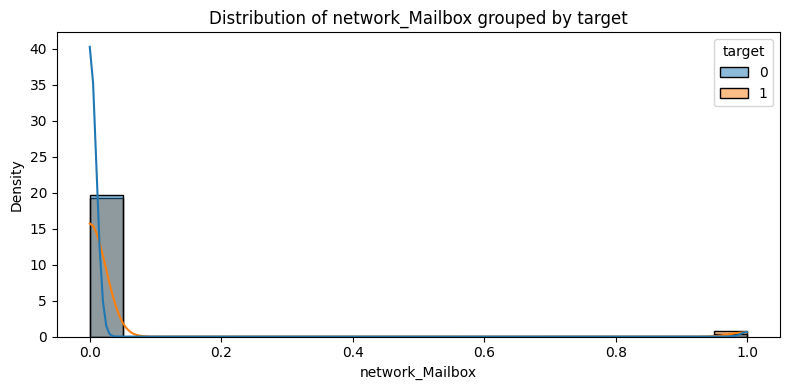

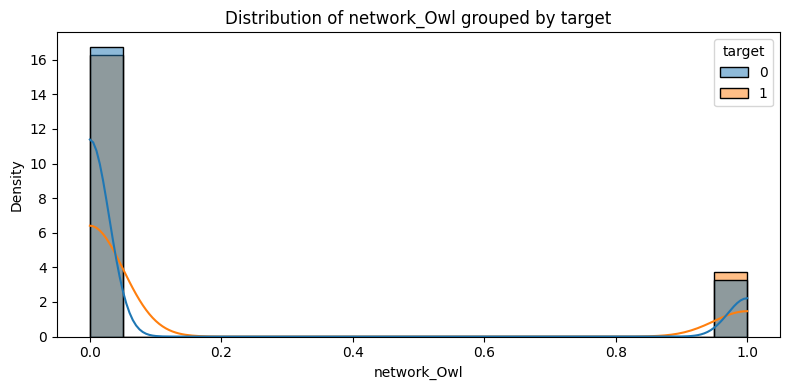

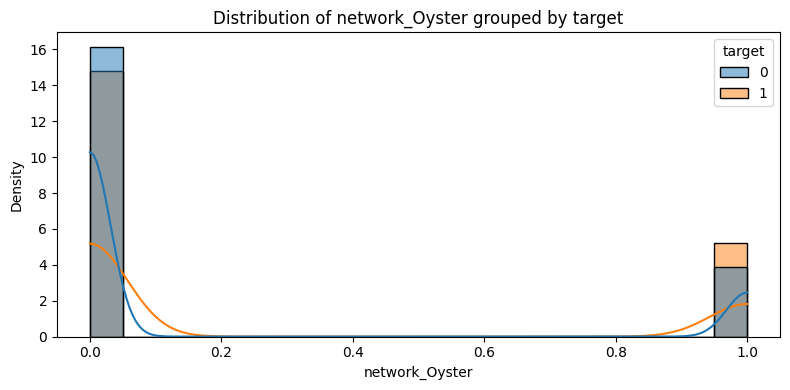

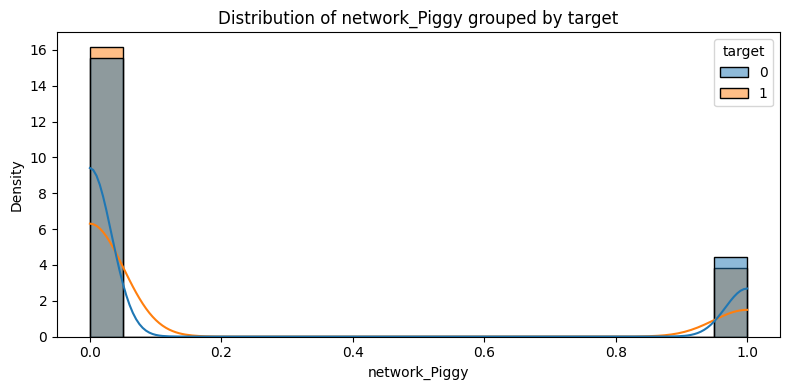

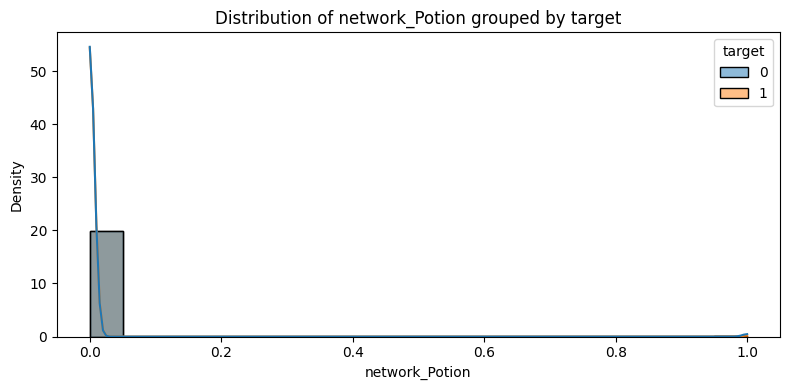

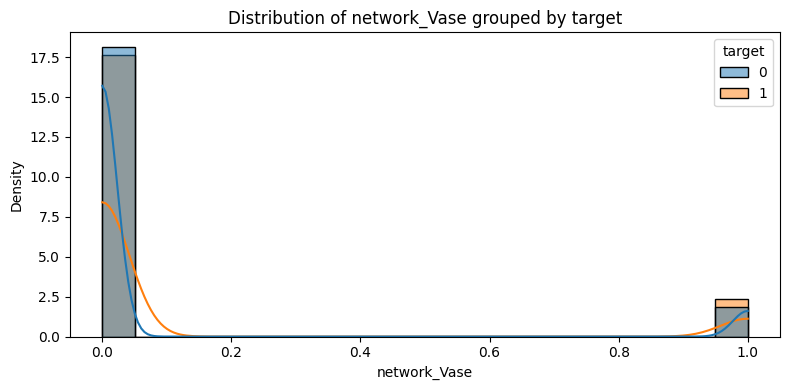

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assume X is your feature matrix DataFrame and y is your target Series.
# Combine them for plotting purposes.
df_plot = X.copy()
df_plot['target'] = y

# Loop through each feature column in X and plot the distribution grouped by target.
for col in X.columns:
    plt.figure(figsize=(8, 4))
    
    # Check if the feature is numeric.
    if pd.api.types.is_numeric_dtype(df_plot[col]):
        # Plot histogram with KDE for numeric features, grouping by target.
        sns.histplot(data=df_plot, x=col, hue='target', kde=True, stat='density', common_norm=False)
        plt.title(f"Distribution of {col} grouped by target")
    
    # For boolean features (one-hot encoded), use a count plot.
    elif pd.api.types.is_bool_dtype(df_plot[col]):
        sns.countplot(x=col, hue='target', data=df_plot)
        plt.title(f"Count distribution of {col} grouped by target")
    
    plt.tight_layout()
    plt.show()


In [93]:
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score

# Assume X and y are already defined (as DataFrames/Series) and represent your feature matrix and target

# 1. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Calculate sample weights for training (balanced weighting)
ratio_0_train = y_train.value_counts(normalize=True).loc[0]
ratio_1_train = y_train.value_counts(normalize=True).loc[1]
sample_weight_train = y_train.replace({0: ratio_1_train, 1: ratio_0_train})

# (For evaluation, if you want to weight test samples similarly:)
ratio_0_test = y_test.value_counts(normalize=True).loc[0]
ratio_1_test = y_test.value_counts(normalize=True).loc[1]
sample_weight_test = y_test.replace({0: ratio_1_test, 1: ratio_0_test})

# 4. Fit a weighted logistic regression using statsmodels GLM
# Add a constant to the training features
X_train_const = sm.add_constant(X_train_scaled)

# Fit the model with frequency weights (note: statsmodels expects weights as a 1-D array)
model_sm = sm.GLM(y_train, X_train_const, family=sm.families.Binomial(), freq_weights=sample_weight_train)
result_sm = model_sm.fit()

print(result_sm.summary())

# 5. Evaluate on the test set
X_test_const = sm.add_constant(X_test_scaled)
y_pred_prob_sm = result_sm.predict(X_test_const)
y_pred_sm = (y_pred_prob_sm >= 0.5).astype(int)

print("Classification Report (unweighted):")
print(classification_report(y_test, y_pred_sm))
print("ROC AUC Score (unweighted):", roc_auc_score(y_test, y_pred_prob_sm))

# Optionally, if you wish to calculate weighted evaluation metrics:
print("Classification Report (weighted):")
print(classification_report(y_test, y_pred_sm, sample_weight=sample_weight_test))
print("ROC AUC Score (weighted):", roc_auc_score(y_test, y_pred_prob_sm, sample_weight=sample_weight_test))


                 Generalized Linear Model Regression Results                  
Dep. Variable:          made_purchase   No. Observations:               274015
Model:                            GLM   Df Residuals:                 39527.82
Model Family:                Binomial   Df Model:                           45
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19494.
Date:                Sun, 16 Feb 2025   Deviance:                       38988.
Time:                        22:06:08   Pearson chi2:                 4.25e+04
No. Iterations:                   100   Pseudo R-squ. (CS):            0.05628
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8214      0.017    -47.111      0.0

In [84]:
for coeff, feature in zip(model.coef_[0], X.columns):
    print(f"{feature}: {coeff}")

age: -0.0010914420281852206
time_spend: 0.1365915842558435
coin_spend: 0.16426474037843133
coin_earn: 1.05376639100593
level_success: -0.18435917293149398
level_fail: -0.008226994302322899
level_start: -0.12447438192457688
booster_spend: 0.25126808334097256
booster_earn: -0.21716071733117398
coin_amount: -0.19290562408691256
event_participate: 0.13562993903687606
shop_open: 0.05665135975514941
country_Amaryllis: 0.20721731044808167
country_Azurelia: -0.0501810219056159
country_Brighthaven: 0.0018758489598458034
country_Crystalbrook: -0.021427805263431497
country_Eldoria: 0.10037141433332512
country_Emberlyn: -0.1291438797845887
country_Floravia: 0.07407621148873374
country_Frostford: -0.20269809964040852
country_Gleamwood: 0.13018091611321198
country_Glimmerdell: 0.016906632481635184
country_Luminara: -0.11823246599130526
country_Moonvale: -0.612520857132762
country_Rosewyn: -0.00629616533737746
country_Seraphina: 0.06987970808810187
country_Silvermist: -0.027120982103181073
country_St

In [91]:
model.coef_

array([[-0.00109144,  0.13659158,  0.16426474,  1.05376639, -0.18435917,
        -0.00822699, -0.12447438,  0.25126808, -0.21716072, -0.19290562,
         0.13562994,  0.05665136,  0.20721731, -0.05018102,  0.00187585,
        -0.02142781,  0.10037141, -0.12914388,  0.07407621, -0.2026981 ,
         0.13018092,  0.01690663, -0.11823247, -0.61252086, -0.00629617,
         0.06987971, -0.02712098, -0.09065879, -0.02087701, -0.12512001,
        -0.21416606,  0.50814479, -0.16369558,  0.16369558, -0.05859881,
        -0.01251265, -0.0655853 , -0.01038372, -0.01879019, -0.06308495,
         0.07528478, -0.02188039,  0.03536882, -0.05142105,  0.01965165,
        -0.03756601, -0.07246339,  0.17169895]])

/home/yusuf/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


UFuncTypeError: Cannot cast ufunc 'inv' input from dtype('O') to dtype('float64') with casting rule 'same_kind'